In [1]:
import numpy as np
import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
%matplotlib inline
from xgcm import Grid
from matplotlib import colors, ticker, cm
from xhistogram.xarray import histogram 
from matplotlib import colors as cols
import pandas as pd

In [2]:
import matplotlib 
font = {'family' : 'sans-serif',
        'size'   : 25}

matplotlib.rc('font', **font)

In [3]:
horispace = 1e3
f =  -1.1E-04

vortband01 = np.linspace(-4, 4, 120)
strainband01 = np.linspace(0, 4, 120)
binbox01 =  (vortband01[1]-vortband01[0])*(strainband01[1]-strainband01[0])

In [4]:
def histTimeSep(vort, strain, timeNum, vortband01, strainband01):
    ### calculate vorticity-strain jpdf given vorticity and strain and specified time range, and bins for both variable
    vortSnap = vort.isel(time=0).load()
    strainSnap = strain.isel(time=0).load()
    hist = histogram(vortSnap.rename('vort'), strainSnap.rename('strain'), dim = ['i','j'] , bins=[vortband01,strainband01])
    hist.load()
    for tid in range(1, timeNum):
        vortSnap = vort.isel(time = tid).load()
        strainSnap = strain.isel(time = tid).load()
        histTemp = histogram(vortSnap.rename('vort'), strainSnap.rename('strain'), dim = ['i','j'] , bins=[vortband01,strainband01])
        histTemp.load()
        hist = hist+histTemp
    hist = hist/timeNum
    return hist

In [5]:
def vortCal(field_u, field_v, ds, grid, f):
    ### calculate normalized vorticity, strain and divergence given u (ds[field_u]) and v (ds[field_v])
    u_transport = grid.interp(ds[field_u],'X', boundary='extend')*ds.DYG 
    v_transport = grid.interp(ds[field_v],'Y', boundary='extend')*ds.DXG 
    div_uv = (grid.diff(u_transport, 'X', boundary='extend') + grid.diff(v_transport, 'Y', boundary='extend')) / ds.RAC
    
    u_cor = grid.interp(ds[field_u],'X', boundary='extend')*ds.DXC
    v_cor = grid.interp(ds[field_v],'Y', boundary='extend')*ds.DYC
    zeta = grid.interp(grid.interp(-grid.diff(u_cor, 'Y', boundary='extend') + grid.diff(v_cor, 'X', boundary='extend'), 'X', boundary='extend'), 'Y', boundary='extend')/ds.RAC

    strain1 = (grid.diff(u_transport, 'X', boundary='extend') - grid.diff(v_transport, 'Y', boundary='extend')) / ds.RAC
    strain2 = grid.interp(grid.interp(grid.diff(u_cor, 'Y', boundary='extend') + grid.diff(v_cor, 'X', boundary='extend'), 'X', boundary='extend'), 'Y', boundary='extend')/ds.RAC
    strain = (strain1**2 + strain2**2)**0.5
    
    zeta_01 = (zeta/f).rename('vort1_0')
    strain_01 = abs(strain/f).rename('strain1_0')
    div_01 = (div_uv/abs(f)).rename('div1_0')
    
    return zeta_01, strain_01, div_01

In [6]:
def vortCal_diff(field_u1, field_u2, field_v1, field_v2, ds, grid, f):
    ### calculate normalized vorticity, strain and divergence given difference of two u fields (ds[field_u1] - ds[field_u2]) and two v fields (ds[field_v1] - ds[field_v2])
    u_transport = grid.interp(ds[field_u1] - ds[field_u2],'X', boundary='extend')*ds.DYG 
    v_transport = grid.interp(ds[field_v1] - ds[field_v2],'Y', boundary='extend')*ds.DXG 
    div_uv = (grid.diff(u_transport, 'X', boundary='extend') + grid.diff(v_transport, 'Y', boundary='extend')) / ds.RAC
    
    u_cor = grid.interp(ds[field_u1] - ds[field_u2],'X', boundary='extend')*ds.DXC
    v_cor = grid.interp(ds[field_v1] - ds[field_v2],'Y', boundary='extend')*ds.DYC
    zeta = grid.interp(grid.interp(-grid.diff(u_cor, 'Y', boundary='extend') + grid.diff(v_cor, 'X', boundary='extend'), 'X', boundary='extend'), 'Y', boundary='extend')/ds.RAC

    strain1 = (grid.diff(u_transport, 'X', boundary='extend') - grid.diff(v_transport, 'Y', boundary='extend')) / ds.RAC
    strain2 = grid.interp(grid.interp(grid.diff(u_cor, 'Y', boundary='extend') + grid.diff(v_cor, 'X', boundary='extend'), 'X', boundary='extend'), 'Y', boundary='extend')/ds.RAC
    strain = (strain1**2 + strain2**2)**0.5
    
    zeta_01 = (zeta/f).rename('vort1_0')
    strain_01 = abs(strain/f).rename('strain1_0')
    div_01 = (div_uv/abs(f)).rename('div1_0')
    
    return zeta_01, strain_01, div_01

In [7]:
dsA = xr.open_zarr('/swot/SUM02/spencer/for_qiyu/vels_regionA_mixed.zarr')
dsB = xr.open_zarr('/swot/SUM02/spencer/for_qiyu/vels_regionB_mixed.zarr')

gridA = Grid(dsA,coords={'X': {'center': 'i', 'left': 'i_g'},'Y': {'center': 'j', 'left': 'j_g'}})
gridB = Grid(dsB,coords={'X': {'center': 'i', 'left': 'i_g'},'Y': {'center': 'j', 'left': 'j_g'}})

# calculate vorticity-strain jpdf for unfiltered velocity, Eulerian filtered velocity, Lagrangian filtered velocity

In [17]:
# field_u = 'unfiltered_u'
# field_v = 'unfiltered_v'

field_u = 'eulfiltered_u'
field_v = 'eulfiltered_v'


# field_u = 'lagfiltered_u'
# field_v = 'lagfiltered_v'

In [18]:
vort_A_eul, strain_A_eul, div_A_eul = vortCal(field_u, field_v, dsA, gridA, f)
vort_B_eul, strain_B_eul, div_B_eul = vortCal(field_u, field_v, dsB, gridB, f)

hist_eul_A_vs = histTimeSep(vort_A_eul.isel(i=slice(10,350), j=slice(10,350)), strain_A_eul.isel(i=slice(10,350), j=slice(10,350)), 30, vortband01, strainband01)
hist_eul_B_vs = histTimeSep(vort_B_eul.isel(i=slice(10,350), j=slice(10,350)), strain_B_eul.isel(i=slice(10,350), j=slice(10,350)), 30, vortband01, strainband01)


### unfiltered velocity, Region A and B

/home/qx344/.conda/envs/mitgcm/lib/python3.6/site-packages/ipykernel/__main__.py:10: UserWarning: The following kwargs were not used by contour: 'rasterized'
/home/qx344/.conda/envs/mitgcm/lib/python3.6/site-packages/ipykernel/__main__.py:29: UserWarning: The following kwargs were not used by contour: 'rasterized'


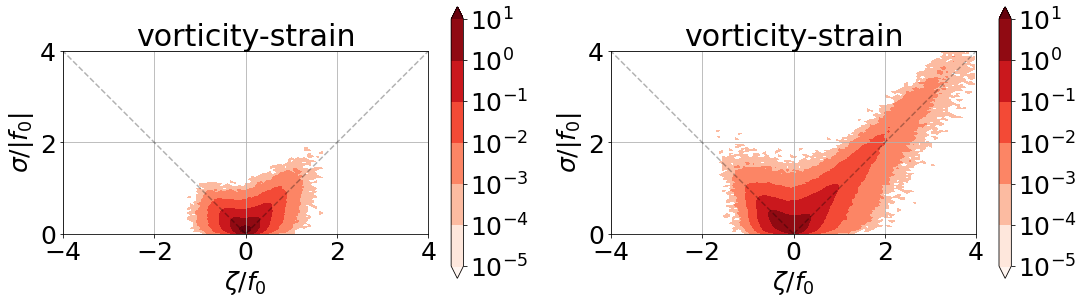

In [12]:
fig, ax = plt.subplots(1,2, figsize=(18,5))

girbNums01 = 320*320


temp20 = (1/(binbox01*girbNums01)*(hist_eul_A_vs.rename('')).T)
temp20 = xr.where(temp20<1e-5,np.nan,temp20)
im00 = ax[0].contourf(temp20.vort_bin, temp20.strain_bin, temp20, 
             locator=ticker.LogLocator(), levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],  cmap='Reds', extend='both', rasterized=True)

h00 = fig.colorbar(im00, ax=ax[0])
ax[0].set_title('vorticity-strain')
ax[0].set_aspect('equal')
ax[0].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[0].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
ax[0].set_xlabel('$\zeta/f_0$')
ax[0].set_ylabel('$\sigma/|f_0|$')
ax[0].set_ylim(0,4)
ax[0].set_xlim(-4,4)
ax[0].set_xticks([-4, -2, 0, 2, 4])
ax[0].grid()



temp20 = (1/(binbox01*girbNums01)*(hist_eul_B_vs.rename('')).T)
temp20 = xr.where(temp20<1e-5,np.nan,temp20)
im01 = ax[1].contourf(temp20.vort_bin, temp20.strain_bin, temp20, 
             locator=ticker.LogLocator(), levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],  cmap='Reds', extend='both', rasterized=True)

h00 = fig.colorbar(im01, ax=ax[1])
ax[1].set_title('vorticity-strain')
ax[1].set_aspect('equal')
ax[1].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[1].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
ax[1].set_xlabel('$\zeta/f_0$')
ax[1].set_ylabel('$\sigma/|f_0|$')
ax[1].set_ylim(0,4)
ax[1].set_xlim(-4,4)
ax[1].set_xticks([-4, -2, 0, 2, 4])
ax[1].grid()

# plt.savefig('un_vs.pdf')

### Lagrangian filtered velocity, Region A and B

/home/qx344/.conda/envs/mitgcm/lib/python3.6/site-packages/ipykernel/__main__.py:10: UserWarning: The following kwargs were not used by contour: 'rasterized'
/home/qx344/.conda/envs/mitgcm/lib/python3.6/site-packages/ipykernel/__main__.py:29: UserWarning: The following kwargs were not used by contour: 'rasterized'


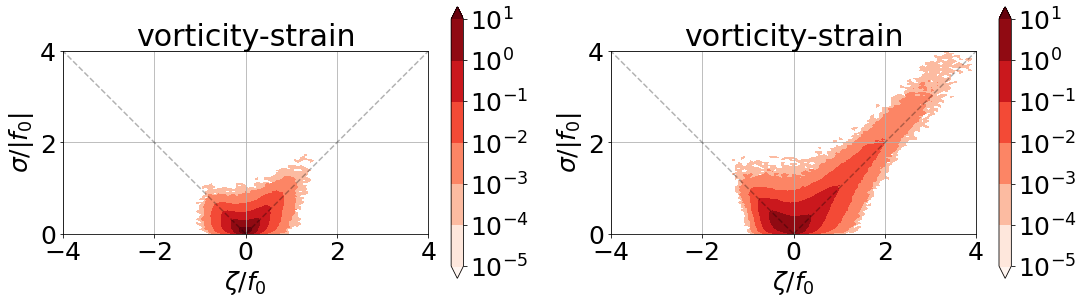

In [16]:
fig, ax = plt.subplots(1,2, figsize=(18,5))

girbNums01 = 320*320


temp20 = (1/(binbox01*girbNums01)*(hist_eul_A_vs.rename('')).T)
temp20 = xr.where(temp20<1e-5,np.nan,temp20)
im00 = ax[0].contourf(temp20.vort_bin, temp20.strain_bin, temp20, 
             locator=ticker.LogLocator(), levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],  cmap='Reds', extend='both', rasterized=True)

h00 = fig.colorbar(im00, ax=ax[0])
ax[0].set_title('vorticity-strain')
ax[0].set_aspect('equal')
ax[0].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[0].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
ax[0].set_xlabel('$\zeta/f_0$')
ax[0].set_ylabel('$\sigma/|f_0|$')
ax[0].set_ylim(0,4)
ax[0].set_xlim(-4,4)
ax[0].set_xticks([-4, -2, 0, 2, 4])
ax[0].grid()



temp20 = (1/(binbox01*girbNums01)*(hist_eul_B_vs.rename('')).T)
temp20 = xr.where(temp20<1e-5,np.nan,temp20)
im01 = ax[1].contourf(temp20.vort_bin, temp20.strain_bin, temp20, 
             locator=ticker.LogLocator(), levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],  cmap='Reds', extend='both', rasterized=True)

h00 = fig.colorbar(im01, ax=ax[1])
ax[1].set_title('vorticity-strain')
ax[1].set_aspect('equal')
ax[1].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[1].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
ax[1].set_xlabel('$\zeta/f_0$')
ax[1].set_ylabel('$\sigma/|f_0|$')
ax[1].set_ylim(0,4)
ax[1].set_xlim(-4,4)
ax[1].set_xticks([-4, -2, 0, 2, 4])
ax[1].grid()

# plt.savefig('lag_vs.pdf')

### Eulerian filtered velocity, Region A and B

/home/qx344/.conda/envs/mitgcm/lib/python3.6/site-packages/ipykernel/__main__.py:10: UserWarning: The following kwargs were not used by contour: 'rasterized'
/home/qx344/.conda/envs/mitgcm/lib/python3.6/site-packages/ipykernel/__main__.py:29: UserWarning: The following kwargs were not used by contour: 'rasterized'


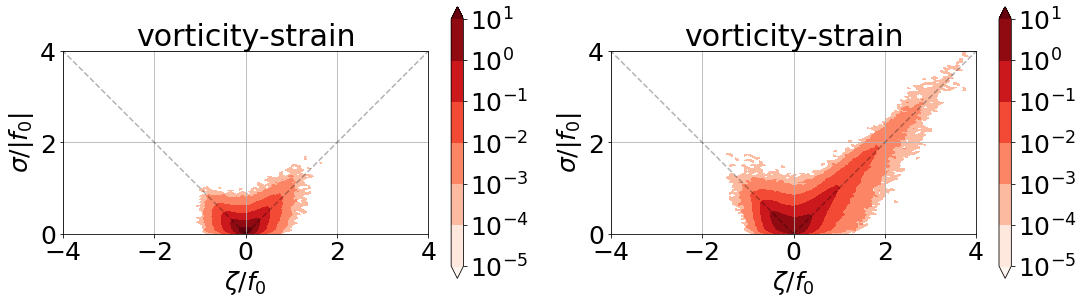

In [19]:
fig, ax = plt.subplots(1,2, figsize=(18,5))

girbNums01 = 320*320


temp20 = (1/(binbox01*girbNums01)*(hist_eul_A_vs.rename('')).T)
temp20 = xr.where(temp20<1e-5,np.nan,temp20)
im00 = ax[0].contourf(temp20.vort_bin, temp20.strain_bin, temp20, 
             locator=ticker.LogLocator(), levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],  cmap='Reds', extend='both', rasterized=True)

h00 = fig.colorbar(im00, ax=ax[0])
ax[0].set_title('vorticity-strain')
ax[0].set_aspect('equal')
ax[0].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[0].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
ax[0].set_xlabel('$\zeta/f_0$')
ax[0].set_ylabel('$\sigma/|f_0|$')
ax[0].set_ylim(0,4)
ax[0].set_xlim(-4,4)
ax[0].set_xticks([-4, -2, 0, 2, 4])
ax[0].grid()



temp20 = (1/(binbox01*girbNums01)*(hist_eul_B_vs.rename('')).T)
temp20 = xr.where(temp20<1e-5,np.nan,temp20)
im01 = ax[1].contourf(temp20.vort_bin, temp20.strain_bin, temp20, 
             locator=ticker.LogLocator(), levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],  cmap='Reds', extend='both', rasterized=True)

h00 = fig.colorbar(im01, ax=ax[1])
ax[1].set_title('vorticity-strain')
ax[1].set_aspect('equal')
ax[1].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[1].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
ax[1].set_xlabel('$\zeta/f_0$')
ax[1].set_ylabel('$\sigma/|f_0|$')
ax[1].set_ylim(0,4)
ax[1].set_xlim(-4,4)
ax[1].set_xticks([-4, -2, 0, 2, 4])
ax[1].grid()

# plt.savefig('eul_vs.pdf')

# calculate vorticity-strain jpdf for difference between unfiltered velocity and Eulerian filtered velocity, Lagrangian filtered velocity

In [24]:

field_u1 = 'unfiltered_u'
field_v1 = 'unfiltered_v'


field_u2 = 'lagfiltered_u'
field_v2 = 'lagfiltered_v'


# field_u2 = 'eulfiltered_u'
# field_v2 = 'eulfiltered_v'


In [25]:
vort_A_eul, strain_A_eul, div_A_eul = vortCal_diff(field_u1, field_u2, field_v1, field_v2, dsA, gridA, f)
vort_B_eul, strain_B_eul, div_B_eul = vortCal_diff(field_u1, field_u2, field_v1, field_v2, dsB, gridB, f)

hist_eul_A_vs = histTimeSep(vort_A_eul.isel(i=slice(10,350), j=slice(10,350)), strain_A_eul.isel(i=slice(10,350), j=slice(10,350)), 30, vortband01, strainband01)
hist_eul_B_vs = histTimeSep(vort_B_eul.isel(i=slice(10,350), j=slice(10,350)), strain_B_eul.isel(i=slice(10,350), j=slice(10,350)), 30, vortband01, strainband01)


### unfiltered velocity - Lagrangian filtered velocity, Region A and B

/home/qx344/.conda/envs/mitgcm/lib/python3.6/site-packages/ipykernel/__main__.py:10: UserWarning: The following kwargs were not used by contour: 'rasterized'
/home/qx344/.conda/envs/mitgcm/lib/python3.6/site-packages/ipykernel/__main__.py:29: UserWarning: The following kwargs were not used by contour: 'rasterized'


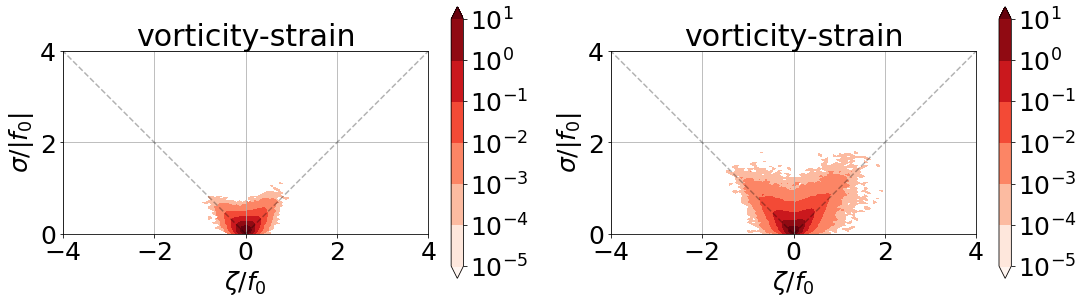

In [26]:
fig, ax = plt.subplots(1,2, figsize=(18,5))

girbNums01 = 320*320


temp20 = (1/(binbox01*girbNums01)*(hist_eul_A_vs.rename('')).T)
temp20 = xr.where(temp20<1e-5,np.nan,temp20)
im00 = ax[0].contourf(temp20.vort_bin, temp20.strain_bin, temp20, 
             locator=ticker.LogLocator(), levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],  cmap='Reds', extend='both', rasterized=True)

h00 = fig.colorbar(im00, ax=ax[0])
ax[0].set_title('vorticity-strain')
ax[0].set_aspect('equal')
ax[0].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[0].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
ax[0].set_xlabel('$\zeta/f_0$')
ax[0].set_ylabel('$\sigma/|f_0|$')
ax[0].set_ylim(0,4)
ax[0].set_xlim(-4,4)
ax[0].set_xticks([-4, -2, 0, 2, 4])
ax[0].grid()



temp20 = (1/(binbox01*girbNums01)*(hist_eul_B_vs.rename('')).T)
temp20 = xr.where(temp20<1e-5,np.nan,temp20)
im01 = ax[1].contourf(temp20.vort_bin, temp20.strain_bin, temp20, 
             locator=ticker.LogLocator(), levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],  cmap='Reds', extend='both', rasterized=True)

h00 = fig.colorbar(im01, ax=ax[1])
ax[1].set_title('vorticity-strain')
ax[1].set_aspect('equal')
ax[1].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[1].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
ax[1].set_xlabel('$\zeta/f_0$')
ax[1].set_ylabel('$\sigma/|f_0|$')
ax[1].set_ylim(0,4)
ax[1].set_xlim(-4,4)
ax[1].set_xticks([-4, -2, 0, 2, 4])
ax[1].grid()

# plt.savefig('lfil_vs.pdf')

### unfiltered velocity - Eulerian filtered velocity, Region A and B

/home/qx344/.conda/envs/mitgcm/lib/python3.6/site-packages/ipykernel/__main__.py:10: UserWarning: The following kwargs were not used by contour: 'rasterized'
/home/qx344/.conda/envs/mitgcm/lib/python3.6/site-packages/ipykernel/__main__.py:29: UserWarning: The following kwargs were not used by contour: 'rasterized'


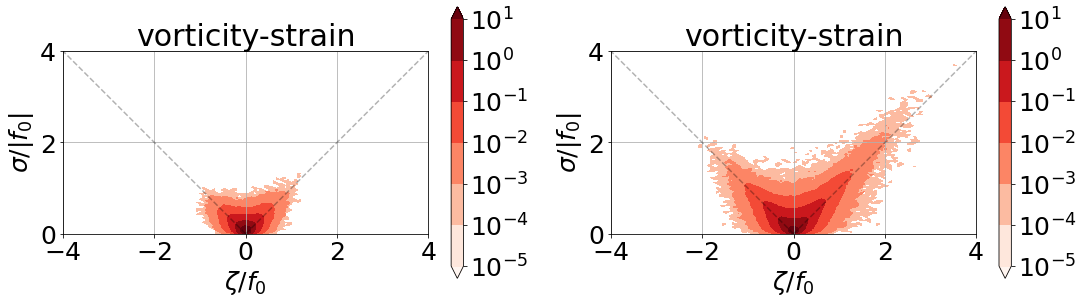

In [23]:
fig, ax = plt.subplots(1,2, figsize=(18,5))

girbNums01 = 320*320


temp20 = (1/(binbox01*girbNums01)*(hist_eul_A_vs.rename('')).T)
temp20 = xr.where(temp20<1e-5,np.nan,temp20)
im00 = ax[0].contourf(temp20.vort_bin, temp20.strain_bin, temp20, 
             locator=ticker.LogLocator(), levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],  cmap='Reds', extend='both', rasterized=True)

h00 = fig.colorbar(im00, ax=ax[0])
ax[0].set_title('vorticity-strain')
ax[0].set_aspect('equal')
ax[0].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[0].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
ax[0].set_xlabel('$\zeta/f_0$')
ax[0].set_ylabel('$\sigma/|f_0|$')
ax[0].set_ylim(0,4)
ax[0].set_xlim(-4,4)
ax[0].set_xticks([-4, -2, 0, 2, 4])
ax[0].grid()



temp20 = (1/(binbox01*girbNums01)*(hist_eul_B_vs.rename('')).T)
temp20 = xr.where(temp20<1e-5,np.nan,temp20)
im01 = ax[1].contourf(temp20.vort_bin, temp20.strain_bin, temp20, 
             locator=ticker.LogLocator(), levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],  cmap='Reds', extend='both', rasterized=True)

h00 = fig.colorbar(im01, ax=ax[1])
ax[1].set_title('vorticity-strain')
ax[1].set_aspect('equal')
ax[1].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[1].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
ax[1].set_xlabel('$\zeta/f_0$')
ax[1].set_ylabel('$\sigma/|f_0|$')
ax[1].set_ylim(0,4)
ax[1].set_xlim(-4,4)
ax[1].set_xticks([-4, -2, 0, 2, 4])
ax[1].grid()

# plt.savefig('efil_vs.pdf')

# calculate vorticity-strain jpdf for unfiltered velocity, $\omega$-k filtered velocity and their difference

In [27]:
def histTimeSep_tang(vort, strain, timeNum, vortband01, strainband01):
    vortSnap = vort.isel(time=0).load()
    strainSnap = strain.isel(time=0).load()
    hist = histogram(vortSnap.rename('vort'), strainSnap.rename('strain'), dim = ['x1','y1'] , bins=[vortband01,strainband01])
    hist.load()
    for tid in range(1, timeNum):
        vortSnap = vort.isel(time = tid).load()
        strainSnap = strain.isel(time = tid).load()
        histTemp = histogram(vortSnap.rename('vort'), strainSnap.rename('strain'), dim = ['x1','y1'] , bins=[vortband01,strainband01])
        histTemp.load()
        hist = hist+histTemp
    hist = hist/timeNum
    return hist

In [28]:
tangridA = Grid(dsA, coords={'X': {'center': 'x1', 'left': 'x1_g'}, 'Y': {'center': 'y1', 'left': 'y1_g'}})
tangridB = Grid(dsB, coords={'X': {'center': 'x1', 'left': 'x1_g'}, 'Y': {'center': 'y1', 'left': 'y1_g'}})


In [40]:
# dsU = dsA['wnfiltered_u']
# dsV = dsA['wnfiltered_v']

dsU = dsB['wnfiltered_u']
dsV = dsB['wnfiltered_v']

# dsU = dsA['unfiltered_u_tp'] - dsA['wnfiltered_u']
# dsV = dsA['unfiltered_v_tp'] - dsA['wnfiltered_v']


# dsU = dsB['unfiltered_u_tp'] - dsB['wnfiltered_u']
# dsV = dsB['unfiltered_v_tp'] - dsB['wnfiltered_v']


In [41]:
u_x = tangridA.interp(tangridA.diff(dsU,'X'),'X')/horispace
u_y = tangridA.interp(tangridA.diff(dsU,'Y'),'Y')/horispace

v_x = tangridA.interp(tangridA.diff(dsV,'X'),'X')/horispace
v_y = tangridA.interp(tangridA.diff(dsV,'Y'),'Y')/horispace


zeta = v_x - u_y
strain = ((u_x - v_y)**2 + (v_x + u_y)**2)**(0.5)


zeta_01 = (zeta/f).isel(x1=slice(100,412),y1=slice(100,412),time=slice(9,61)).rename('vort1_0')
strain_01 = abs(strain/f).isel(x1=slice(100,412),y1=slice(100,412),time=slice(9,61)).rename('strain1_0')

In [ ]:
hist_wfil_A_vs = histTimeSep_tang(zeta_01, strain_01, 30, vortband01, strainband01)
hist_wfil_B_vs = histTimeSep_tang(zeta_01, strain_01, 30, vortband01, strainband01)

In [ ]:
hist_wnl_A_vs = histTimeSep_tang(zeta_01, strain_01, 30, vortband01, strainband01)
hist_wnl_B_vs = histTimeSep_tang(zeta_01, strain_01, 30, vortband01, strainband01)

### $\omega$-k filtered velocity, Region A and B

/home/qx344/.conda/envs/mitgcm/lib/python3.6/site-packages/ipykernel/__main__.py:10: UserWarning: The following kwargs were not used by contour: 'rasterized'
/home/qx344/.conda/envs/mitgcm/lib/python3.6/site-packages/ipykernel/__main__.py:29: UserWarning: The following kwargs were not used by contour: 'rasterized'


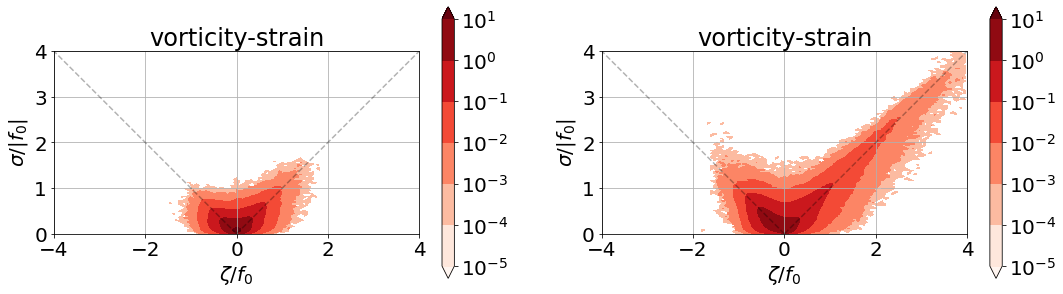

In [31]:
# window
fig, ax = plt.subplots(1,2, figsize=(18,5))

girbNums01 = 312*312


temp20 = (1/(binbox01*girbNums01)*(hist_wnl_A_vs.rename('')).T)
temp20 = xr.where(temp20<1e-5,np.nan,temp20)
im00 = ax[0].contourf(temp20.vort_bin, temp20.strain_bin, temp20, 
             locator=ticker.LogLocator(), levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],  cmap='Reds', extend='both', rasterized=True)

h00 = fig.colorbar(im00, ax=ax[0])
ax[0].set_title('vorticity-strain')
ax[0].set_aspect('equal')
ax[0].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[0].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
ax[0].set_xlabel('$\zeta/f_0$')
ax[0].set_ylabel('$\sigma/|f_0|$')
ax[0].set_ylim(0,4)
ax[0].set_xlim(-4,4)
ax[0].set_xticks([-4, -2, 0, 2, 4])
ax[0].grid()



temp20 = (1/(binbox01*girbNums01)*(hist_wnl_B_vs.rename('')).T)
temp20 = xr.where(temp20<1e-5,np.nan,temp20)
im01 = ax[1].contourf(temp20.vort_bin, temp20.strain_bin, temp20, 
             locator=ticker.LogLocator(), levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],  cmap='Reds', extend='both', rasterized=True)

h00 = fig.colorbar(im01, ax=ax[1])
ax[1].set_title('vorticity-strain')
ax[1].set_aspect('equal')
ax[1].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[1].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
ax[1].set_xlabel('$\zeta/f_0$')
ax[1].set_ylabel('$\sigma/|f_0|$')
ax[1].set_ylim(0,4)
ax[1].set_xlim(-4,4)
ax[1].set_xticks([-4, -2, 0, 2, 4])
ax[1].grid()

plt.savefig('win_vs.pdf')

### unfiltered velocity - Eulerian filtered velocity, Region A and B

/home/qx344/.conda/envs/mitgcm/lib/python3.6/site-packages/ipykernel/__main__.py:10: UserWarning: The following kwargs were not used by contour: 'rasterized'
/home/qx344/.conda/envs/mitgcm/lib/python3.6/site-packages/ipykernel/__main__.py:29: UserWarning: The following kwargs were not used by contour: 'rasterized'


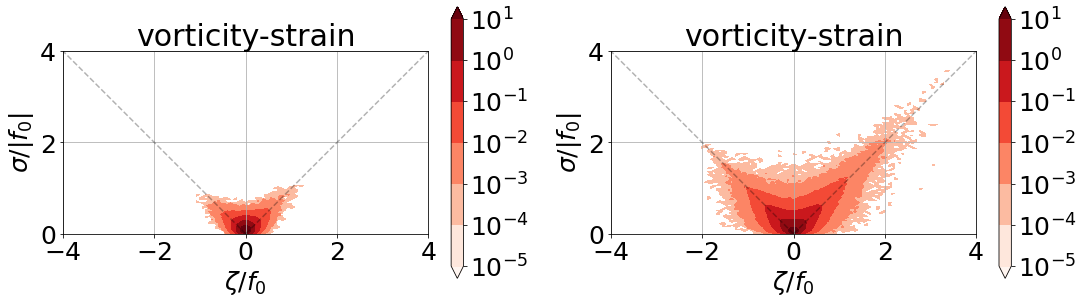

In [36]:
# window
fig, ax = plt.subplots(1,2, figsize=(18,5))

girbNums01 = 312*312


temp20 = (1/(binbox01*girbNums01)*(hist_wfil_A_vs.rename('')).T)
temp20 = xr.where(temp20<1e-5,np.nan,temp20)
im00 = ax[0].contourf(temp20.vort_bin, temp20.strain_bin, temp20, 
             locator=ticker.LogLocator(), levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],  cmap='Reds', extend='both', rasterized=True)

h00 = fig.colorbar(im00, ax=ax[0])
ax[0].set_title('vorticity-strain')
ax[0].set_aspect('equal')
ax[0].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[0].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
ax[0].set_xlabel('$\zeta/f_0$')
ax[0].set_ylabel('$\sigma/|f_0|$')
ax[0].set_ylim(0,4)
ax[0].set_xlim(-4,4)
ax[0].set_xticks([-4, -2, 0, 2, 4])
ax[0].grid()



temp20 = (1/(binbox01*girbNums01)*(hist_wfil_B_vs.rename('')).T)
temp20 = xr.where(temp20<1e-5,np.nan,temp20)
im01 = ax[1].contourf(temp20.vort_bin, temp20.strain_bin, temp20, 
             locator=ticker.LogLocator(), levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],  cmap='Reds', extend='both', rasterized=True)

h00 = fig.colorbar(im01, ax=ax[1])
ax[1].set_title('vorticity-strain')
ax[1].set_aspect('equal')
ax[1].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[1].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
ax[1].set_xlabel('$\zeta/f_0$')
ax[1].set_ylabel('$\sigma/|f_0|$')
ax[1].set_ylim(0,4)
ax[1].set_xlim(-4,4)
ax[1].set_xticks([-4, -2, 0, 2, 4])
ax[1].grid()

plt.savefig('wfil_vs.pdf')